In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import sys,os
from tqdm import tqdm_notebook as tqdm

c = 'Kaggle-IEEE-CIS-Fraud-Detection-2019'
root = 'F:/home/daishu/competition/%s/'%c
id_name = 'TransactionID'
label_name = 'isFraud'

In [2]:
train_df1 = pd.read_csv('%s/data/train_identity.csv'%root)
train_df2 = pd.read_csv('%s/data/train_transaction.csv'%root)

test_df1 = pd.read_csv('%s/data/test_identity.csv'%root)
test_df2 = pd.read_csv('%s/data/test_transaction.csv'%root)

In [3]:
train_df1.shape,train_df2.shape

((144233, 41), (590540, 394))

In [4]:
train_df = train_df2.merge(train_df1,how='left',on=id_name)
test_df = test_df2.merge(test_df1,how='left',on=id_name)

In [5]:
del train_df1,train_df2,test_df1,test_df2
train_df.shape

(590540, 434)

In [66]:
for c in ['card%s'%(i+1) for i in range(6)]:
    print(c,train_df[c].nunique())

card1 13553
card2 500
card3 114
card4 4
card5 119
card6 4


In [69]:
for c in ['card%s'%(i+1) for i in range(6)]:
    inter = set(train_df[c].unique()) & set(test_df[c].unique())
    print(c,sum(test_df[c].isin(inter))/test_df.shape[0])

card1 0.9815272029698574
card2 0.9826442545851416
card3 0.9939844994286459
card4 1.0
card5 0.9909195150496062
card6 1.0


In [64]:
for c in ['C%s'%(i+1) for i in range(14)]:
    print(c,sum(train_df[c]==0),train_df.loc[train_df[c]==0,label_name].mean(),train_df[c].corr(train_df[label_name]))

C1 494 0.3643724696356275 0.030569759651239932
C2 443 0.05191873589164785 0.03722893953099858
C3 588111 0.035126022128475744 -0.006833173826653219
C4 451883 0.02038580783078806 0.03038213630507711
C5 372435 0.05036852068146119 -0.030753966713252066
C6 49066 0.031304773162678844 0.02090898355378391
C7 523142 0.02437579089425051 0.028160291640634834
C8 447667 0.020899463217078765 0.032138713158291844
C9 183795 0.06668298919992383 -0.031703415864193916
C10 453442 0.02127284195112054 0.02839598745679023
C11 1864 0.06813304721030043 0.02748373459887533
C12 489199 0.022896612625945677 0.031905281711224746
C13 35460 0.1410321489001692 -0.01114575222904826
C14 35947 0.1450468745653323 0.007920558690607874


In [29]:
train_df['card4'].unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

In [43]:
df

,a,b
0,2,1
1,2,2
2,1,1
3,2,2
4,2,2
5,3,1
6,1,1
7,3,2
8,4,1
9,1,2


In [46]:
def Get_count_sum(x,shift=0):
    x = list(range(shift,len(x)+shift))
    if shift != 0:
        x = np.roll(x,shift)
        for i in range(shift):
            x[i] = 0 
    return x

def Get_cum_sum(x,shift=0):
    if shift != 0:
        x = np.roll(x,shift)
        for i in range(shift):
            x[i] = 0
    return np.cumsum(x)
df = pd.DataFrame({'a':np.random.randint(1,5,10000),'b':np.random.randint(0,2,10000)})
df.groupby(['a'])['b'].transform(lambda x:Get_cum_sum(x,1))

0          0
1          0
2          0
3          0
4          1
5          2
6          3
7          4
8          0
9          1
10         0
11         1
12         2
13         5
14         2
15         3
16         6
17         1
18         3
19         2
20         3
21         4
22         4
23         3
24         7
25         8
26         8
27         9
28         5
29        10
        ... 
9970    1231
9971    1232
9972    1303
9973    1214
9974    1215
9975    1232
9976    1216
9977    1303
9978    1216
9979    1232
9980    1304
9981    1305
9982    1232
9983    1232
9984    1306
9985    1216
9986    1238
9987    1238
9988    1307
9989    1238
9990    1238
9991    1216
9992    1233
9993    1234
9994    1238
9995    1216
9996    1216
9997    1217
9998    1239
9999    1239
Name: b, Length: 10000, dtype: int32

In [2]:
def Count_encoding(df,cols,sparseThreshold=50):
    for col in cols:
        print(col)
        df['tmp'] = df[col].map(dict(df[col].value_counts())).astype(int)
        df.loc[df['tmp']<sparseThreshold,col] = df.loc[df['tmp']<sparseThreshold,'tmp'].astype(str)
        df.loc[df['tmp']>=sparseThreshold,col] = df.loc[df['tmp']>=sparseThreshold,'tmp'].astype(str) + '_' + df.loc[df['tmp']>=sparseThreshold,col].astype(str)
        df[col] = df[col].rank(method='dense')
    df.drop(['tmp'],axis=1,inplace=True)
    return df

train_df = pd.read_csv('%s/data/new_train_best.csv'%root,nrows=None)
test_df = pd.read_csv('%s/data/new_test_best.csv'%root,nrows=None)
unique_card_train_df = pd.read_csv('%s/data/uniqueCradTrain.csv'%root,nrows=None)
unique_card_test_df = pd.read_csv('%s/data/uniqueCradTest.csv'%root,nrows=None)
train_df = train_df.merge(unique_card_train_df,how='left',on=id_name)
test_df = test_df.merge(unique_card_test_df,how='left',on=id_name)
del unique_card_train_df,unique_card_test_df

tt_df = train_df.append(test_df)
cols = [col for col in tt_df.columns if 'TranDist' in col]
tt_df = Count_encoding(tt_df,cols)
#tt_df = tt_df.drop(drop_cols,axis=1)
train_df = tt_df[:train_df.shape[0]]
test_df = tt_df[train_df.shape[0]:]
del tt_df

uniqueCrad0_lastTranDist
uniqueCrad0_nextTranDist
uniqueCrad1_lastTranDist
uniqueCrad1_nextTranDist
uniqueCrad2_lastTranDist
uniqueCrad2_nextTranDist


In [4]:
train_df['TransactionDT'] = pd.read_csv('%s/data/train_transaction.csv'%root,usecols=['TransactionDT'])['TransactionDT']
test_df['TransactionDT'] = pd.read_csv('%s/data/test_transaction.csv'%root,usecols=['TransactionDT'])['TransactionDT']

In [83]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [84]:
test_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
def Information_entropy(x):
    x = pd.Series(x)
    pct = x.groupby(by=x).count() / len(x)
    return np.sum(-pct*np.log2(pct))

def Mutual_information(x,y):
    df = pd.DataFrame({'x':x,'y':y})
    entropy = Information_entropy(y)
    conditiona_entropy = df.groupby(['x']).agg({'y':Information_entropy})
    pct = df.groupby(['x']).count() / len(x)
    return entropy - np.sum(pct.values*conditiona_entropy.values)

def Data_review(trainDf,testDf,idName,labelName):
    info = []
    info.append([idName,'object',trainDf.shape[0],testDf.shape[0],0,'0.00%','0.00%',np.nan,np.nan,np.nan,np.nan,np.nan])
    info.append([labelName,trainDf[labelName].dtype,trainDf.shape[0],testDf.shape[0],np.nan,np.nan,np.nan,trainDf[labelName].mean(),np.nan,np.nan,np.nan,np.nan])
    for col in tqdm(trainDf.columns):
        if col in [idName,labelName]:
            continue
        data_type = trainDf[col].dtype
        train_nunique = trainDf[col].nunique() + (trainDf[col].isna().sum()>0)
        test_nunique = testDf[col].nunique() + (testDf[col].isna().sum()>0)
        train_test_intersection = set(trainDf[col].unique())&(set(testDf[col].unique()))
        train_intersectiom_pct = '%.2f%%'%(trainDf.loc[trainDf[col].isin(train_test_intersection)].shape[0]/trainDf.shape[0]*100)
        test_intersectiom_pct = '%.2f%%'%(testDf.loc[testDf[col].isin(train_test_intersection)].shape[0]/testDf.shape[0]*100)
        if data_type == 'object':
            train_mode_or_mean = trainDf[col].mode().values[0]
            test_mode_or_mean = testDf[col].mode().values[0]
            mi_or_corr = Mutual_information(trainDf[col],trainDf[labelName])
        else:
            train_mode_or_mean = trainDf[col].mean()
            test_mode_or_mean = testDf[col].mean()
            mi_or_corr = trainDf[col].corr(trainDf[labelName])
        train_nan_num = trainDf[col].isnull().sum()
        test_nan_num = testDf[col].isnull().sum()
        info.append([col,data_type,train_nunique,test_nunique,len(train_test_intersection),train_intersectiom_pct,test_intersectiom_pct,train_mode_or_mean,test_mode_or_mean,train_nan_num,test_nan_num,mi_or_corr])
    info_df = pd.DataFrame(info,columns=['column','dataType','trainNunique','testNunique','trainTestIntersection','trainIntersectionPct','testIntersectionPct','trainModeOrMean','testModeOrMean','trainNanNum','testNanNum','miOrCorr'])
    return info_df

In [86]:
info_df = Data_review(train_df,test_df,id_name,label_name)

KeyboardInterrupt: 

In [11]:
info_df.to_csv('%s/data/info.csv'%root,index=False)
info_df

,column,dataType,trainNunique,testNunique,trainTestIntersection,intersectionPct,trainModeOrMean,testModeOrMean,trainNanNum,testNanNum,miOrCorr
0,TransactionID,object,590540,506691,0.0,0.00%,NaN,NaN,NaN,NaN,NaN
1,isFraud,int64,590540,506691,NaN,NaN,0.03499,NaN,NaN,NaN,NaN
2,TransactionDT,int64,573349,494686,0.0,0.00%,7.37231e+06,2.69299e+07,0.0,0.0,0.013103
3,TransactionAmt,float64,20902,14119,5215.0,24.95%,135.027,134.726,0.0,0.0,0.011320
4,ProductCD,object,5,5,5.0,100.00%,W,W,0.0,0.0,0.014839
5,card1,int64,13553,13244,9706.0,71.62%,9898.73,9957.22,0.0,0.0,-0.013640
6,card2,float64,501,498,496.0,99.00%,362.555,363.735,8933.0,8654.0,0.003388
7,card3,float64,115,116,96.0,83.48%,153.195,153.543,1565.0,3002.0,0.154151
8,card4,object,5,5,5.0,100.00%,visa,visa,1577.0,3086.0,0.000809
9,card5,float64,120,103,83.0,69.17%,199.279,200.163,4259.0,4547.0,-0.033580


In [18]:
sorted(list(train_df['TransactionAmt'].unique()),reverse=True)

[31937.391,
 6450.97,
 6085.23,
 5543.23,
 5420.0,
 5366.82,
 5279.95,
 5278.95,
 5277.95,
 5191.0,
 5094.95,
 5047.47,
 5001.82,
 4989.97,
 4976.31,
 4879.95,
 4843.75,
 4836.33,
 4829.95,
 4817.58,
 4817.47,
 4652.92,
 4633.34,
 4631.0,
 4606.58,
 4592.02,
 4577.7,
 4548.35,
 4547.47,
 4545.36,
 4517.71,
 4515.95,
 4463.95,
 4452.07,
 4451.95,
 4437.95,
 4425.97,
 4409.87,
 4394.95,
 4391.0,
 4322.17,
 4309.19,
 4301.95,
 4299.36,
 4298.41,
 4222.95,
 4220.39,
 4199.55,
 4194.95,
 4191.0,
 4146.66,
 4114.62,
 4113.77,
 4077.08,
 4072.95,
 4072.7,
 4062.97,
 4041.08,
 4039.96,
 4026.97,
 4022.95,
 4011.95,
 4007.95,
 4006.79,
 3996.53,
 3991.47,
 3986.8,
 3984.95,
 3983.51,
 3975.79,
 3967.81,
 3945.95,
 3941.08,
 3929.51,
 3891.0,
 3866.7,
 3848.32,
 3839.97,
 3839.95,
 3829.81,
 3826.3,
 3822.95,
 3786.27,
 3704.01,
 3694.95,
 3684.11,
 3644.95,
 3619.95,
 3618.31,
 3594.95,
 3584.95,
 3582.95,
 3565.95,
 3555.95,
 3555.75,
 3546.95,
 3545.06,
 3535.62,
 3511.95,
 3501.28,
 3500.0,


In [19]:
sorted(test_df['TransactionAmt'].unique(),reverse=True)

[10270.0,
 9801.5,
 9601.5,
 9333.0,
 9154.46,
 8814.5,
 7926.42,
 7777.49,
 6759.0,
 6609.95,
 6532.95,
 6279.95,
 6222.0,
 6197.36,
 6079.95,
 5979.95,
 5976.8,
 5858.16,
 5605.46,
 5487.36,
 5279.95,
 5191.0,
 5139.97,
 5094.95,
 5041.0,
 5011.95,
 5007.95,
 4979.95,
 4962.07,
 4922.95,
 4892.81,
 4884.8,
 4838.87,
 4812.95,
 4790.95,
 4785.83,
 4751.95,
 4723.19,
 4692.25,
 4691.0,
 4688.02,
 4687.89,
 4663.67,
 4645.5,
 4631.19,
 4604.95,
 4595.8,
 4573.79,
 4550.5,
 4525.97,
 4499.95,
 4492.72,
 4481.62,
 4451.95,
 4442.26,
 4424.07,
 4415.55,
 4369.66,
 4366.95,
 4340.55,
 4327.02,
 4306.95,
 4305.13,
 4292.83,
 4222.95,
 4212.42,
 4191.0,
 4182.95,
 4164.69,
 4164.64,
 4148.55,
 4139.85,
 4138.92,
 4127.9,
 4122.95,
 4111.47,
 4095.5,
 4094.95,
 4093.78,
 4092.52,
 4075.24,
 4062.43,
 4046.19,
 4046.18,
 4041.0,
 4031.47,
 4007.95,
 4004.3,
 3986.06,
 3980.62,
 3976.71,
 3975.67,
 3972.11,
 3957.95,
 3948.46,
 3941.0,
 3932.35,
 3922.95,
 3904.88,
 3902.6,
 3891.54,
 3865.38,
 

In [159]:
id_cols = ['id_12','id_15','id_16','id_27','id_28','id_29']
train_df.loc[((train_df[id_cols]=='NotFound').sum(axis=1)>0),'isFraud'].mean()

0.08172634717244441

In [63]:
cols = ['D1','V281','V282','V283','V288','V289','V296','V300','V301','V313','V314','V315']
for col in cols:
    train_df[col] = train_df[col].fillna(-999)
train_df['f'] = train_df[cols].sum(axis=1)

In [78]:
train_df[['V306','TransactionAmt',label_name]].corr()

,V306,TransactionAmt,isFraud
V306,1.000000,0.035334,-0.00187
TransactionAmt,0.035334,1.000000,0.01132
isFraud,-0.001870,0.011320,1.00000


In [70]:
f = 'V307'
train_df[[f,label_name]].groupby([f]).agg(['count','mean']).sort_values(by=[('isFraud','count')],ascending=False)

isFraud          
                count      mean
V307                           
0.000000       316650  0.032023
107.949997       6360  0.007862
57.950001        5672  0.004231
59.000000        5418  0.014766
117.000000       5247  0.023442
100.000000       3307  0.037194
49.000000        2687  0.026796
50.000000        2291  0.031864
226.000000       2280  0.032456
47.950001        2248  0.003559
200.000000       2005  0.052868
35.950001        1937  0.004130
39.000000        1771  0.018069
30.950001        1704  0.002347
209.949997       1675  0.011343
150.000000       1586  0.073770
215.899994       1581  0.017710
29.000000        1549  0.014848
25.950001        1541  0.002596
115.900002       1538  0.005202
171.000000       1445  0.032526
159.949997       1314  0.006849
67.949997        1291  0.003098
234.000000       1261  0.038858
34.000000        1239  0.014528
77.000000        1232  0.034903
300.000000       1183  0.089603
118.000000       1183  0.013525
335.000000       1110  0.038739
165.899994       1013  0.007897
...               ...       ...
96.400597           1  0.000000
547.989990          1  0.000000
547.900024          1  0.000000
96.406998           1  0.000000
547.799988          1  0.000000
96.419998           1  0.000000
549.619995          1  0.000000
96.309502           1  0.000000
549.789978          1  0.000000
96.295700           1  0.000000
550.979980          1  1.000000
550.969971          1  0.000000
550.960022          1  0.000000
96.078400           1  0.000000
96.093300           1  1.000000
550.880005          1  0.000000
550.869995          1  0.000000
550.849976          1  0.000000
96.154701           1  0.000000
550.799988          1  0.000000
550.585205          1  1.000000
96.189201           1  0.000000
550.002197          1  1.000000
96.202003           1  0.000000
96.246902           1  0.000000
549.900024          1  0.000000
96.277702           1  0.000000
549.827271          1  0.000000
549.820007          1  0.000000
145765.000000       1  0.000000

[37368 rows x 2 columns]

In [71]:
f = 'TransactionAmt'
train_df[[f,label_name]].groupby([f]).agg(['count','mean']).sort_values(by=[('isFraud','count')],ascending=False)

isFraud          
                 count      mean
TransactionAmt                  
59.000           30582  0.021124
117.000          28933  0.024851
107.950          23954  0.009226
57.950           23600  0.003814
100.000          20362  0.025685
50.000           17009  0.020754
49.000           15990  0.029331
226.000          11704  0.033322
39.000           11095  0.021812
29.000           10683  0.018815
47.950            9655  0.003521
35.950            8909  0.002918
150.000           8356  0.067137
171.000           7682  0.035407
34.000            7652  0.018296
30.950            7649  0.003791
25.000            7500  0.017467
77.000            7389  0.035999
25.950            7294  0.002879
200.000           6590  0.064188
209.950           6115  0.008504
335.000           5534  0.042284
67.950            5403  0.003331
75.000            5107  0.025064
159.950           4716  0.011450
97.000            4678  0.045532
92.000            4280  0.033879
58.950            3798  0.005003
30.000            3571  0.026603
108.950           3564  0.007576
...                ...       ...
393.470              1  0.000000
393.500              1  0.000000
393.670              1  0.000000
393.700              1  0.000000
393.760              1  0.000000
71.884               1  0.000000
393.810              1  0.000000
392.460              1  0.000000
392.450              1  0.000000
392.400              1  0.000000
391.920              1  0.000000
391.370              1  0.000000
391.400              1  0.000000
391.600              1  0.000000
391.650              1  0.000000
72.177               1  0.000000
391.780              1  0.000000
391.800              1  0.000000
72.150               1  0.000000
72.146               1  0.000000
392.390              1  0.000000
72.097               1  0.000000
391.990              1  0.000000
392.020              1  0.000000
392.050              1  0.000000
392.160              1  0.000000
392.200              1  0.000000
392.250              1  0.000000
392.320              1  0.000000
0.251                1  0.000000

[20902 rows x 2 columns]

In [ ]:
train_df['DeviceInfo'] = train_df['DeviceInfo'].fillna('-999').apply(lambda x:x.lower())
def Get_device(x):
    os_list = ['sm','ios','mac','linux','android','func']
    for o in os_list:
        if o in x:
            return o
    return x
train_df['f'] = train_df['id_30'].apply(lambda x:Get_os(x))

In [156]:
f = 'DeviceInfo'
train_df[[f,label_name]].groupby([f]).agg(['count','mean']).sort_values(by=[('isFraud','count')],ascending=False)

isFraud          
                                 count      mean
DeviceInfo                                      
Windows                          47722  0.065400
iOS Device                       19782  0.062683
MacOS                            12573  0.022111
Trident/7.0                       7440  0.012903
rv:11.0                           1901  0.039979
rv:57.0                            962  0.107069
SM-J700M Build/MMB29K              549  0.109290
SM-G610M Build/MMB29K              461  0.080260
SM-G531H Build/LMY48B              410  0.080488
rv:59.0                            362  0.121547
SM-G935F Build/NRD90M              334  0.092814
SM-G955U Build/NRD90M              328  0.100610
SM-G532M Build/MMB29T              316  0.037975
ALE-L23 Build/HuaweiALE-L23        312  0.092949
SM-G950U Build/NRD90M              290  0.055172
SM-G930V Build/NRD90M              274  0.000000
rv:58.0                            269  0.182156
rv:52.0                            256  0.046875
SAMSUNG                            235  0.021277
SM-G950F Build/NRD90M              225  0.151111
Moto G (4) Build/NPJ25.93-14.7     219  0.182648
SM-N950U Build/NMF26X              209  0.062201
SM-A300H Build/LRX22G              203  0.832512
hi6210sft Build/MRA58K             190  0.947368
SM-J730GM Build/NRD90M             184  0.146739
SM-G570M Build/MMB29K              182  0.016484
rv:48.0                            178  0.011236
CAM-L03 Build/HUAWEICAM-L03        172  0.127907
SM-J320M Build/LMY47V              171  0.333333
LG-M700 Build/NMF26X               169  0.171598
...                                ...       ...
SAMSUNG-SM-G890A                     1  0.000000
SAMSUNG-SM-G900A                     1  0.000000
SAMSUNG-SM-G925A                     1  0.000000
SAMSUNG-SM-G930AZ                    1  0.000000
SAMSUNG-SM-J327AZ                    1  0.000000
SAMSUNG-SM-N920A                     1  0.000000
SAMSUNG-SM-T377A                     1  0.000000
SAMSUNG-SM-T537A                     1  0.000000
S6000                                1  0.000000
S471                                 1  0.000000
Robin                                1  0.000000
Redmi Note 5A Build/N2G47H           1  0.000000
Northwell                            1  0.000000
O1                                   1  0.000000
ORION                                1  0.000000
P00A                                 1  0.000000
P01M                                 1  0.000000
P027                                 1  0.000000
PLAYTAB                              1  0.000000
PLE-701L                             1  0.000000
PLK-L01 Build/HONORPLK-L01           1  0.000000
PMID7102DC                           1  0.000000
PRA507                               1  0.000000
QMV7A                                1  0.000000
QTASUN1                              1  0.000000
QwestIE8                             1  0.000000
R8106                                1  0.000000
0PJA2                                1  0.000000
RCT6K03W13                           1  0.000000
xs-Z47b7VqTMxs                       1  0.000000

[1786 rows x 2 columns]

In [91]:
Mutual_information(train_df.loc[train_df['f']!='-999',label_name],train_df.loc[train_df['f']!='-999','f'])

0.00642022551406396

In [ ]:
info_df

In [11]:
info_df.to_csv('%s/data/info.csv'%root,index=False)

In [116]:
train_df[['f',label_name]].sort_values(by=['f'],ascending=False)

,f,isFraud
526013,4545.360000,0
489105,3454.950000,0
128466,3381.950000,0
429425,3263.490000,0
296902,3221.000000,1
124785,2741.770000,0
91420,2629.970000,0
154137,2594.950000,0
151608,2594.940000,0
526080,2463.930000,0


In [122]:
train_df.loc[tmp['card']=='2102_555_143_visa_102_credit']

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,f
296902,3283902,1,7333909,3221.0,W,2102,555.0,143.0,visa,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3221.0


In [49]:
def Get_groupby_f(df,f):
    return df.groupby([f])[label_name].agg(['count','mean']).sort_values(by=['count'],ascending=False)

In [50]:
Get_groupby_f(tmp,'card1')

,count,mean
card1,,
7919,14932,0.007501
9500,14162,0.037283
15885,10361,0.042853
17188,10344,0.026875
15066,7945,0.039396
12695,7091,0.028346
12544,6773,0.021556
6019,6771,0.043420
2803,6141,0.011887


In [41]:
tmp.loc[tmp['card1']==9917,list(tmp.columns)[:11]]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
401020,3388020,1,10108000,78.667,C,9917,142.0,185.0,visa,138.0,debit
401047,3388047,1,10108394,78.667,C,9917,142.0,185.0,visa,138.0,debit
401144,3388144,1,10109872,81.446,C,9917,142.0,185.0,visa,138.0,debit
401152,3388152,1,10109982,81.446,C,9917,142.0,185.0,visa,138.0,debit
401164,3388164,1,10110148,40.723,C,9917,142.0,185.0,visa,138.0,debit
401166,3388166,1,10110185,40.723,C,9917,142.0,185.0,visa,138.0,debit
401204,3388204,1,10110631,40.723,C,9917,142.0,185.0,visa,138.0,debit
401206,3388206,1,10110664,78.667,C,9917,142.0,185.0,visa,138.0,debit
401251,3388251,1,10111633,40.723,C,9917,142.0,185.0,visa,138.0,debit
401258,3388258,1,10111686,40.723,C,9917,142.0,185.0,visa,138.0,debit


In [39]:
tmp.loc[tmp['card1']==9917,list(tmp.columns)[:11]].groupby(['TransactionAmt'])[label_name].agg(['count','mean'])

,count,mean
TransactionAmt,,
9.667,1,0.0
12.326,1,0.0
28.156,1,0.0
28.277,4,0.5
29.183,10,1.0
30.210,1,1.0
32.264,1,1.0
36.856,4,1.0
40.723,9,1.0


In [56]:
tmp.loc[(tmp['card1']==9917)&(tmp['TransactionAmt']>=28.27)&(tmp['TransactionAmt']<=28.28),list(tmp.columns)[:17]]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
401393,3388393,1,10114050,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,yahoo.com,yahoo.com
401506,3388506,0,10116475,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com
401708,3388708,1,10122531,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,yahoo.com,yahoo.com
401795,3388795,0,10125587,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,yahoo.com,yahoo.com


In [10]:
train_df['V258'].unique()

array([nan,  1.,  2.,  3., 60.,  4., 61., 62., 63.,  8.,  5.,  6., 64.,
        9., 65., 66.,  7., 35., 36., 46., 44., 45., 47., 10., 11., 48.,
       12., 13., 49., 14., 50., 51., 52., 53., 54., 55., 56., 15., 57.,
       58., 59., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 37., 38., 39., 40., 41.,
       42., 43.,  0.])

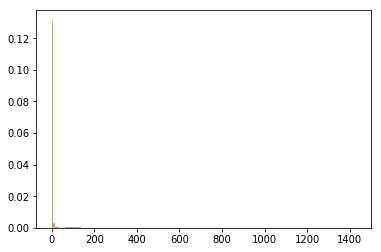

In [36]:
c = 'C14'
is_log = False
if is_log:
    v1 = np.log(train_df[c].dropna())
    v2 = np.log(test_df[c].dropna())
else:
    v1 = train_df[c].dropna()
    v2 = test_df[c].dropna()
min_value = min(min(v1),min(v2))
max_value = max(max(v1),max(v2))
bins = np.linspace(min_value,max_value,200)
plt.hist(v1,bins=bins,alpha=0.5,normed=True)
plt.hist(v2,bins=bins,alpha=0.5,normed=True)
plt.show()

In [169]:
train_df[['C1','C4','C8','C12','C13','C14']].corr()

,C1,C4,C8,C12,C13,C14
C1,1.000000,0.967800,0.967746,0.927939,0.774603,0.951761
C4,0.967800,1.000000,0.959995,0.894619,0.644549,0.907676
C8,0.967746,0.959995,1.000000,0.983027,0.653245,0.860246
C12,0.927939,0.894619,0.983027,1.000000,0.631704,0.793936
C13,0.774603,0.644549,0.653245,0.631704,1.000000,0.880722
C14,0.951761,0.907676,0.860246,0.793936,0.880722,1.000000


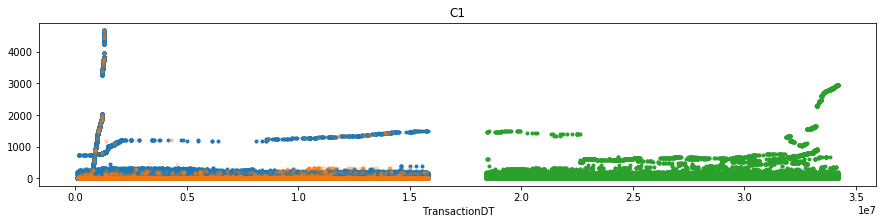

In [167]:
c = 'C1'
train_df.loc[train_df[label_name]==0].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
train_df.loc[train_df[label_name]==1].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3),alpha=0.1)

test_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
plt.show()

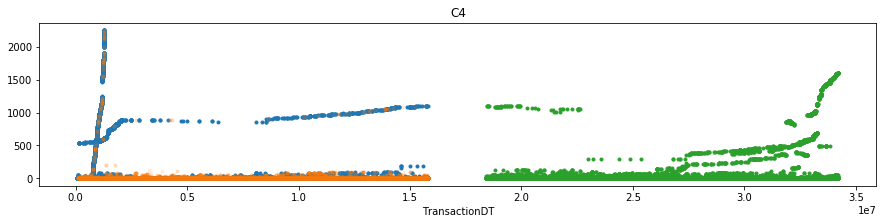

In [168]:
c = 'C4'
train_df.loc[train_df[label_name]==0].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
train_df.loc[train_df[label_name]==1].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3),alpha=0.1)

test_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
plt.show()

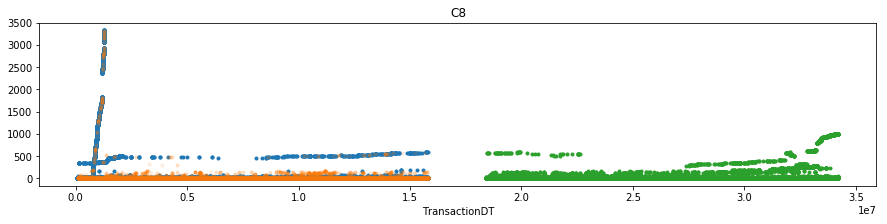

In [148]:
c = 'C8'
train_df.loc[train_df[label_name]==0].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
train_df.loc[train_df[label_name]==1].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3),alpha=0.1)

test_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
plt.show()

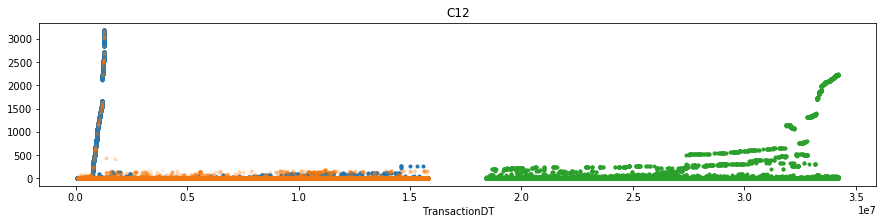

In [162]:
c = 'C12'
train_df.loc[train_df[label_name]==0].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
train_df.loc[train_df[label_name]==1].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3),alpha=0.1)

test_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
plt.show()

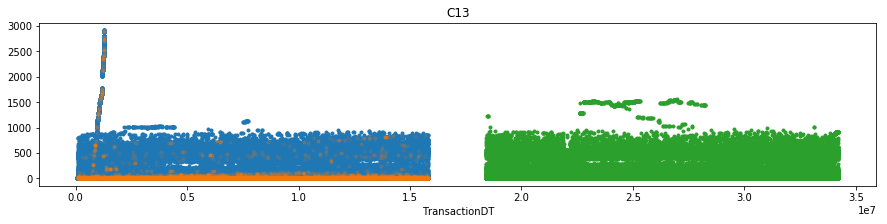

In [149]:
c = 'C13'
train_df.loc[train_df[label_name]==0].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
train_df.loc[train_df[label_name]==1].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3),alpha=0.1)

test_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
plt.show()

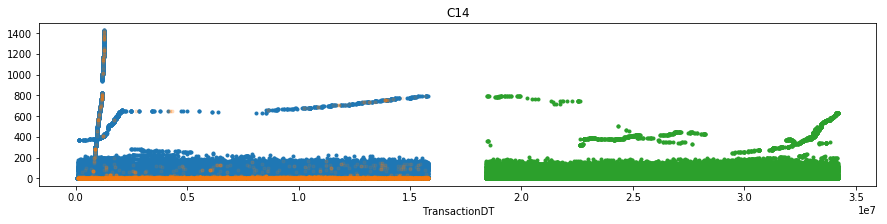

In [150]:
c = 'C14'
train_df.loc[train_df[label_name]==0].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
train_df.loc[train_df[label_name]==1].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3),alpha=0.1)

test_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
plt.show()

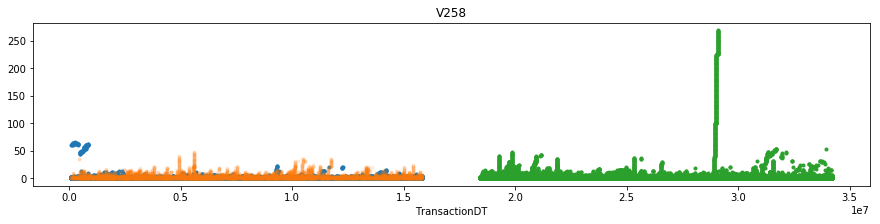

In [21]:
c = 'V258'
train_df[c] = train_df[c].replace(-999,np.nan)
test_df[c] = test_df[c].replace(-999,np.nan)

train_df.loc[train_df[label_name]==0].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
train_df.loc[train_df[label_name]==1].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3),alpha=0.1)

test_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
plt.show()

In [7]:
a=['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'D1', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'DeviceInfo', 'DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'TransactionAmt', 'V1', 'V10', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V11', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V12', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V13', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V14', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V15', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V16', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V17', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V18', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V19', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V2', 'V20', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V21', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V22', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V23', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V24', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V25', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V26', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V27', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V28', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V29', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V3', 'V30', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V31', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V32', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V33', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V4', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V5', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V6', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V7', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V8', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V9', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'addr1', 'addr2', 'cNanNum', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'cardNanNum', 'dNanNum', 'deviceNanNum', 'dist1', 'dist2', 'emailNanNum', 'idNanNum', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'mNanNum', 'nanNum', 'vNanNum', 'TransactionAmtDecimal', 'TransactionAmtDecimalLength', 'day', 'dayOfWeek', 'hour', 'day_TransactionAmtDivCount', 'day_TransactionAmtDivMean', 'day_TransactionAmtDivstd', 'day_TransactionAmtDecimalDivCount', 'day_TransactionAmtDecimalDivMean', 'day_TransactionAmtDecimalDivstd', 'day_id_02DivCount', 'day_id_02DivMean', 'day_id_02Divstd', 'day_D1DivMean', 'day_D2DivMean', 'day_D3DivMean', 'day_D4DivMean', 'day_D5DivMean', 'day_D6DivMean', 'day_D7DivMean', 'day_D8DivMean', 'day_D9DivMean', 'day_D10DivMean', 'day_D11DivMean', 'day_D12DivMean', 'day_D13DivMean', 'day_D14DivMean', 'day_D15DivMean', 'card1_TransactionAmtDivCount', 'card1_TransactionAmtDivMean', 'card1_TransactionAmtDivstd', 'card1_TransactionAmtDecimalDivCount', 'card1_TransactionAmtDecimalDivMean', 'card1_TransactionAmtDecimalDivstd', 'card1_id_02DivCount', 'card1_id_02DivMean', 'card1_id_02Divstd', 'card4_TransactionAmtDivCount', 'card4_TransactionAmtDivMean', 'card4_TransactionAmtDivstd', 'card4_TransactionAmtDecimalDivCount', 'card4_TransactionAmtDecimalDivMean', 'card4_TransactionAmtDecimalDivstd', 'card4_id_02DivCount', 'card4_id_02DivMean', 'card4_id_02Divstd', 'uniqueCrad0', 'uniqueCrad0_TransactionAmtDivCount', 'uniqueCrad0_TransactionAmtDivMean', 'uniqueCrad0_TransactionAmtDivstd', 'uniqueCrad0_TransactionAmtDecimalDivCount', 'uniqueCrad0_TransactionAmtDecimalDivMean', 'uniqueCrad0_TransactionAmtDecimalDivstd', 'uniqueCrad0_id_02DivCount', 'uniqueCrad0_id_02DivMean', 'uniqueCrad0_id_02Divstd', 'uniqueCrad1', 'uniqueCrad1_TransactionAmtDivCount', 'uniqueCrad1_TransactionAmtDivMean', 'uniqueCrad1_TransactionAmtDivstd', 'uniqueCrad1_TransactionAmtDecimalDivCount', 'uniqueCrad1_TransactionAmtDecimalDivMean', 'uniqueCrad1_TransactionAmtDecimalDivstd', 'uniqueCrad1_id_02DivCount', 'uniqueCrad1_id_02DivMean', 'uniqueCrad1_id_02Divstd', 'uniqueCrad2', 'uniqueCrad2_TransactionAmtDivCount', 'uniqueCrad2_TransactionAmtDivMean', 'uniqueCrad2_TransactionAmtDivstd', 'uniqueCrad2_TransactionAmtDecimalDivCount', 'uniqueCrad2_TransactionAmtDecimalDivMean', 'uniqueCrad2_TransactionAmtDecimalDivstd', 'uniqueCrad2_id_02DivCount', 'uniqueCrad2_id_02DivMean', 'uniqueCrad2_id_02Divstd', 'notFountNum', 'os', 'chrome', 'w', 'h', 'w-h', 'area', 'ratio', 'TF', 'M1-M9', 'nan-12-3', 'nan-134-0', 'nan-1269-6031', 'nan-77096-12899', 'nan-89164-12081', 'nan-168922-76851', 'nan-279287-176518', 'nan-271100-176639', 'nan-346252-235004', 'nan-446307-364784', 'nan-449121-369375', 'nan-449555-369714', 'nan-449562-369913', 'nan-450721-370316', 'nan-450909-369957', 'nan-453675-371941', 'nan-508589-430636', 'nan-508595-430906', 'nan-515614-432353', 'nan-524216-440210', 'nan-585371-501629', 'nan-585385-501632', 'uniqueCrad0_lastTranTD', 'uniqueCrad0_nextTranTD', 'uniqueCrad0_lastTranDist', 'uniqueCrad0_nextTranDist', 'uniqueCrad1_lastTranTD', 'uniqueCrad1_nextTranTD', 'uniqueCrad1_lastTranDist', 'uniqueCrad1_nextTranDist', 'uniqueCrad2_lastTranTD', 'uniqueCrad2_nextTranTD', 'uniqueCrad2_lastTranDist', 'uniqueCrad2_nextTranDist']
b=['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'D1', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'DeviceInfo', 'DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'TransactionAmt', 'V1', 'V10', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V11', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V12', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V13', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V14', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V15', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V16', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V17', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V18', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V19', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V2', 'V20', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V21', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V22', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V23', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V24', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V25', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V26', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V27', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V28', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V29', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V3', 'V30', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V31', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V32', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V33', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V4', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V5', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V6', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V7', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V8', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V9', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'addr1', 'addr2', 'cNanNum', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'cardNanNum', 'dNanNum', 'deviceNanNum', 'dist1', 'dist2', 'emailNanNum', 'idNanNum', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'mNanNum', 'nanNum', 'vNanNum', 'TransactionAmtDecimal', 'TransactionAmtDecimalLength', 'day', 'dayOfWeek', 'hour', 'day_TransactionAmtDivCount', 'day_TransactionAmtDivMean', 'day_TransactionAmtDivstd', 'day_TransactionAmtDecimalDivCount', 'day_TransactionAmtDecimalDivMean', 'day_TransactionAmtDecimalDivstd', 'day_id_02DivCount', 'day_id_02DivMean', 'day_id_02Divstd', 'day_D1DivMean', 'day_D2DivMean', 'day_D3DivMean', 'day_D4DivMean', 'day_D5DivMean', 'day_D6DivMean', 'day_D7DivMean', 'day_D8DivMean', 'day_D9DivMean', 'day_D10DivMean', 'day_D11DivMean', 'day_D12DivMean', 'day_D13DivMean', 'day_D14DivMean', 'day_D15DivMean', 'card1_TransactionAmtDivCount', 'card1_TransactionAmtDivMean', 'card1_TransactionAmtDivstd', 'card1_TransactionAmtDecimalDivCount', 'card1_TransactionAmtDecimalDivMean', 'card1_TransactionAmtDecimalDivstd', 'card1_id_02DivCount', 'card1_id_02DivMean', 'card1_id_02Divstd', 'card4_TransactionAmtDivCount', 'card4_TransactionAmtDivMean', 'card4_TransactionAmtDivstd', 'card4_TransactionAmtDecimalDivCount', 'card4_TransactionAmtDecimalDivMean', 'card4_TransactionAmtDecimalDivstd', 'card4_id_02DivCount', 'card4_id_02DivMean', 'card4_id_02Divstd', 'uniqueCrad0', 'uniqueCrad0_TransactionAmtDivCount', 'uniqueCrad0_TransactionAmtDivMean', 'uniqueCrad0_TransactionAmtDivstd', 'uniqueCrad0_TransactionAmtDecimalDivCount', 'uniqueCrad0_TransactionAmtDecimalDivMean', 'uniqueCrad0_TransactionAmtDecimalDivstd', 'uniqueCrad0_id_02DivCount', 'uniqueCrad0_id_02DivMean', 'uniqueCrad0_id_02Divstd', 'uniqueCrad1', 'uniqueCrad1_TransactionAmtDivCount', 'uniqueCrad1_TransactionAmtDivMean', 'uniqueCrad1_TransactionAmtDivstd', 'uniqueCrad1_TransactionAmtDecimalDivCount', 'uniqueCrad1_TransactionAmtDecimalDivMean', 'uniqueCrad1_TransactionAmtDecimalDivstd', 'uniqueCrad1_id_02DivCount', 'uniqueCrad1_id_02DivMean', 'uniqueCrad1_id_02Divstd', 'uniqueCrad2', 'uniqueCrad2_TransactionAmtDivCount', 'uniqueCrad2_TransactionAmtDivMean', 'uniqueCrad2_TransactionAmtDivstd', 'uniqueCrad2_TransactionAmtDecimalDivCount', 'uniqueCrad2_TransactionAmtDecimalDivMean', 'uniqueCrad2_TransactionAmtDecimalDivstd', 'uniqueCrad2_id_02DivCount', 'uniqueCrad2_id_02DivMean', 'uniqueCrad2_id_02Divstd', 'notFountNum', 'os', 'chrome', 'w', 'h', 'w-h', 'area', 'ratio', 'TF', 'M1-M9', 'nan-12-3', 'nan-134-0', 'nan-1269-6031', 'nan-77096-12899', 'nan-89164-12081', 'nan-168922-76851', 'nan-279287-176518', 'nan-271100-176639', 'nan-346252-235004', 'nan-446307-364784', 'nan-449121-369375', 'nan-449555-369714', 'nan-449562-369913', 'nan-450721-370316', 'nan-450909-369957', 'nan-453675-371941', 'nan-508589-430636', 'nan-508595-430906', 'nan-515614-432353', 'nan-524216-440210', 'nan-585371-501629', 'nan-585385-501632', 'uniqueCrad0_lastTranTD', 'uniqueCrad0_nextTranTD', 'uniqueCrad0_lastTranDist', 'uniqueCrad0_nextTranDist', 'uniqueCrad1_lastTranTD', 'uniqueCrad1_nextTranTD', 'uniqueCrad1_lastTranDist', 'uniqueCrad1_nextTranDist', 'uniqueCrad2_lastTranTD', 'uniqueCrad2_nextTranTD', 'uniqueCrad2_lastTranDist', 'uniqueCrad2_nextTranDist']
set(b)-set(a)

set()

0 0


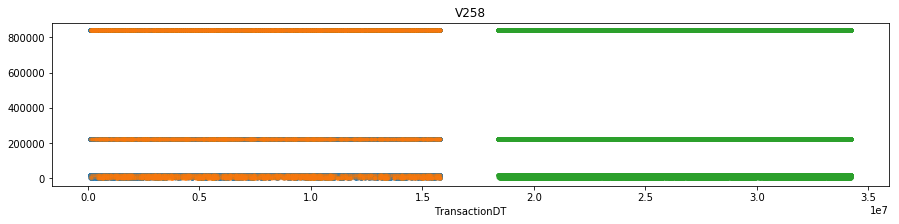

In [5]:
c = 'V258'
print(train_df[c].isna().sum(),test_df[c].isna().sum())
train_df.loc[train_df[label_name]==0].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
train_df.loc[train_df[label_name]==1].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3),alpha=0.1)
#train_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))

test_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
plt.show()

460110 379963


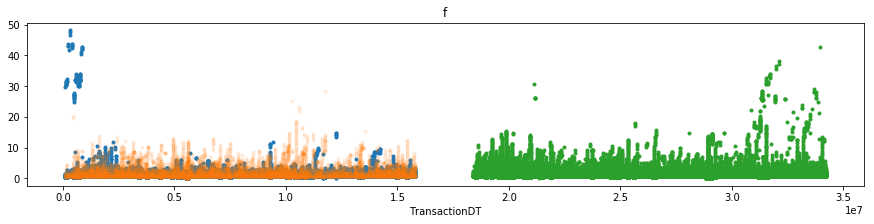

In [83]:
c = 'f'
print(train_df[c].isna().sum(),test_df[c].isna().sum())
train_df.loc[train_df[label_name]==0].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
train_df.loc[train_df[label_name]==1].set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3),alpha=0.1)
#train_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))

test_df.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3))
plt.show()

In [45]:
def Get_ave_interval(x):
    if len(x) < 2:
        return -999
    else:
        return np.mean(np.diff(x))

In [68]:
c = 'V258'
train_df['f'] = train_df[c].map(dict(train_df.groupby([c])['TransactionDT'].agg(Get_ave_interval)))
test_df['f'] = test_df[c].map(dict(test_df.groupby([c])['TransactionDT'].agg(Get_ave_interval)))

In [62]:
a=dict(train_df.groupby([c])['TransactionDT'].agg(Get_ave_interval))

In [82]:
c = 'V258'
train_df['day'] = train_df['TransactionDT'] // 86400
x = train_df.groupby(['day'])[c].transform('mean')
print(x.max())
train_df['f'] = (train_df[c]) / x
print(train_df['f'].min())
#train_df['f'] = train_df['f'] / x
test_df['day'] = test_df['TransactionDT'] // 86400
x = test_df.groupby(['day'])[c].transform('mean') 
test_df['f'] = (test_df[c]) / x

3.9318518518518517
0.0


In [69]:
new_train_df = pd.read_csv('%s/data/new_train.csv'%root)

In [71]:
card_cols = ['card%s'%(i+1) for i in range(6)]
addr_cols = ['addr1','addr2']
email_cols = ['P_emaildomain','R_emaildomain']
c_cols = ['C%s'%(i+1) for i in range(14)]
d_cols = ['D%s'%(i+1) for i in range(15)]
m_cols = ['M%s'%(i+1) for i in range(9)]
v_cols = ['V%s'%(i+1) for i in range(339)]
id_cols = ['id_%s'%str(i+1).zfill(2) for i in range(38)]
device_cols = ['DeviceType','DeviceInfo']
cat_cols = card_cols+['ProductCD','addr1','addr2']+email_cols+m_cols+['id_%s'%str(i+1).zfill(2) for i in range(11,38)]+device_cols
new_train_df[[id_name]+cat_cols+v_cols].to_csv('%s/data/valueCountTrain.csv'%root,index=False)

In [72]:
new_test_df = pd.read_csv('%s/data/new_test.csv'%root)
new_test_df[[id_name]+cat_cols+v_cols].to_csv('%s/data/valueCountTest.csv'%root,index=False)

In [128]:
train_df.groupby(['f'])[label_name].agg(['count','mean']).sort_values(by=['count'],ascending=False)

,count,mean
f,,
0.000000,402886,0.021691
0.035498,8126,0.025105
1.000000,7417,0.038425
0.040594,3564,0.028900
0.199640,3541,0.029653
0.043746,3096,0.097222
0.038849,2076,0.041426
0.041715,2073,0.065123
0.034359,1603,0.048659


In [131]:
train_df.groupby(['f'])[label_name].agg(['count','mean'])#.sort_values(by=['count'],ascending=False)

,count,mean
f,,
0.000000,402886,0.021691
0.000751,1,0.000000
0.000810,1,0.000000
0.000923,1,0.000000
0.000995,1,0.000000
0.001045,1,1.000000
0.001047,1,0.000000
0.001076,1,0.000000
0.001183,1,0.000000


In [129]:
train_df.groupby(['C4'])[label_name].agg(['count','mean']).sort_values(by=['count'],ascending=False)

,count,mean
C4,,
0.0,451883,0.020386
1.0,111817,0.051298
2.0,12994,0.128444
3.0,4949,0.144070
4.0,1902,0.305468
5.0,851,0.404230
6.0,597,0.402010
7.0,372,0.325269
9.0,273,0.545788


In [220]:
train_df[['f']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 1 columns):
f    58846 non-null float64
dtypes: float64(1)
memory usage: 29.0 MB


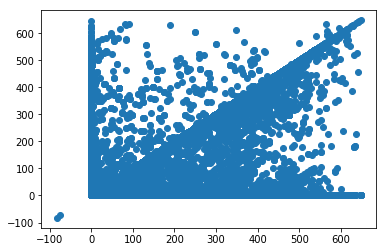

In [221]:
plt.plot(train_df['D12'].values,train_df['D15'].values,'o')

In [10]:
def Get_new_feature(df):
    df['f'] = df['V258'] - (df['V257'])
    return df
train_df = Get_new_feature(train_df)
test_df = Get_new_feature(test_df)

In [174]:
for i in range(6):
    for j in range(i+1,6):
        print(i,j)

0 1
0 2
0 3
0 4
0 5
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


In [94]:
train_df.loc[train_df['D15']==0,['card%s'%(i+1) for i in range(6)]+['addr1','addr2']+['P_emaildomain','R_emaildomain']].tail()

,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain
590529,5096,555.0,185.0,mastercard,137.0,credit,NaN,NaN,gmail.com,gmail.com
590530,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,yahoo.com,NaN
590534,5812,408.0,185.0,mastercard,224.0,debit,NaN,NaN,gmail.com,gmail.com
590536,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,gmail.com,NaN
590537,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,gmail.com,NaN


In [77]:
def Get_card_id(df):
    card_info = ['card%s'%(i+1) for i in range(6)]
    card_info.extend(['addr1','addr2','P_emaildomain','R_emaildomain'])
    tmp = df[card_info]
    for col in tmp.columns:
        tmp[col] = tmp[col].astype(str).apply(lambda x:x.replace('.0',''))
    tmp['card'] = tmp[card_info].apply(lambda x:'_'.join(x),axis=1)
    return tmp
tmp = Get_card_id(train_df)

In [78]:
tmp['card'].nunique()

114187

In [13]:
tmp.head()

,card1,card2,card3,card4,card5,card6,addr1,addr2,card
0,13926,nan,150,discover,142,credit,315,87,13926_nan_150_discover_142_credit_315_87
1,2755,404,150,mastercard,102,credit,325,87,2755_404_150_mastercard_102_credit_325_87
2,4663,490,150,visa,166,debit,330,87,4663_490_150_visa_166_debit_330_87
3,18132,567,150,mastercard,117,debit,476,87,18132_567_150_mastercard_117_debit_476_87
4,4497,514,150,mastercard,102,credit,420,87,4497_514_150_mastercard_102_credit_420_87


In [71]:
info_df.to_csv('%s/data/info.csv'%root,index=False)

In [11]:
train_df['id_03'].nunique()

24

In [17]:
def Get_card_id(df):
    card_info = ['card%s'%(i+1) for i in range(6)]
    card_info.extend(['P_emaildomain','R_emaildomain'])
    tmp = df[card_info]
    for col in tmp.columns:
        tmp[col] = tmp[col].astype(str).apply(lambda x:x.replace('.0',''))
    tmp['card'] = tmp[card_info].apply(lambda x:'_'.join(x),axis=1)
    return tmp

In [79]:
tmp1 = Get_card_id(test_df)

In [80]:
print(tmp1.loc[tmp1['card'].isin(tmp['card'])].shape[0]/tmp1.shape[0])

0.7989859697527685


In [16]:
#tmp = Get_card_id(train_df)
tmp

,card1,card2,card3,card4,card5,card6,addr1,addr2,card,isFraud
0,13926,nan,150,discover,142,credit,315,87,13926_nan_150_discover_142_credit_315_87,0
1,2755,404,150,mastercard,102,credit,325,87,2755_404_150_mastercard_102_credit_325_87,0
2,4663,490,150,visa,166,debit,330,87,4663_490_150_visa_166_debit_330_87,0
3,18132,567,150,mastercard,117,debit,476,87,18132_567_150_mastercard_117_debit_476_87,0
4,4497,514,150,mastercard,102,credit,420,87,4497_514_150_mastercard_102_credit_420_87,0
5,5937,555,150,visa,226,debit,272,87,5937_555_150_visa_226_debit_272_87,0
6,12308,360,150,visa,166,debit,126,87,12308_360_150_visa_166_debit_126_87,0
7,12695,490,150,visa,226,debit,325,87,12695_490_150_visa_226_debit_325_87,0
8,2803,100,150,visa,226,debit,337,87,2803_100_150_visa_226_debit_337_87,0
9,17399,111,150,mastercard,224,debit,204,87,17399_111_150_mastercard_224_debit_204_87,0


In [48]:
tmp['card'].nunique()

61858

In [14]:
tmp[label_name] = train_df[label_name]

In [63]:
card = '1724_583_150_visa_226_credit_299_87'
print(train_df.loc[(tmp['card']==card),label_name].mean())
train_df.loc[(tmp['card']==card),['isFraud','TransactionDT','C15']]

0.03197674418604651


,isFraud,TransactionDT,C15
22,0,86786,NaN
275,0,90723,NaN
3375,0,154959,NaN
9102,0,263458,NaN
11090,0,331607,NaN
11675,0,340223,NaN
12198,0,347305,NaN
12537,0,352748,NaN
12628,0,354533,NaN
12659,0,354988,NaN


In [25]:
train_df.loc[(tmp['card']==card)&(train_df[label_name]==1),['isFraud','TransactionDT','C6']]

,isFraud,TransactionDT,C6
73408,1,1628511,1.0
124488,1,2470793,1.0
124537,1,2471934,1.0
142788,1,2933006,1.0
282052,1,6890208,1.0
488108,1,12706039,2.0
488116,1,12706217,2.0
488147,1,12707084,3.0
488149,1,12707182,3.0
488946,1,12755136,1.0


In [112]:
np.roll(train_df.loc[(tmp['card']=='5812_408_185_mastercard_224_debit'),'TransactionDT'].diff(),-1)

array([1759., 1643.,  163., ...,  693., 2821.,   nan])

In [72]:
test_df.loc[(tmp1['card']=='9500_321_150_visa_226_debit_59_W'),test_df.columns[:15]]

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain
115,3663664,18405989,59.0,W,9500,321.0,150.0,visa,226.0,debit,204.0,87.0,NaN,NaN,gmail.com
149,3663698,18406862,59.0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,NaN,NaN,gmail.com
203,3663752,18409256,59.0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,2.0,NaN,NaN
1358,3664907,18471867,59.0,W,9500,321.0,150.0,visa,226.0,debit,330.0,87.0,11.0,NaN,yahoo.com
1427,3664976,18473350,59.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,NaN,NaN,yahoo.com
1874,3665423,18482001,59.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,NaN,NaN,gmail.com
1946,3665495,18483619,59.0,W,9500,321.0,150.0,visa,226.0,debit,433.0,87.0,0.0,NaN,NaN
2070,3665619,18486230,59.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,1.0,NaN,NaN
2365,3665914,18492145,59.0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,60.0,NaN,gmail.com
2430,3665979,18493731,59.0,W,9500,321.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,gmail.com


In [74]:
train_df[['id_%s'%str(i+1).zfill(2) for i in range(38)]].head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [161]:
new_train_df = pd.read_csv('%s/data/new_train.csv'%root)

In [162]:
new_train_df.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,isFraud,mNanNum,nanNum,uniqueCrad0,uniqueCrad0_lastTranDist,uniqueCrad0_lastTranTD,uniqueCrad0_nextTranDist,uniqueCrad0_nextTranTD,vNanNum,uniqueCrad0_amtDivCount
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,3,234,1.0,-817119_-817119_315_87,9999999.0,315_87_-817119_-817119,9999999.0,177,68.500000
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,6,230,37.0,-817119_-817119_325_87,99999999.0,325_87_205_87,14970.0,170,1.208333
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,211,56.0,-817119_-817119_330_87,99999999.0,330_87_184_87,256.0,159,1.552632
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,...,0,6,227,30.0,-817119_-817119_476_87,99999999.0,476_87_204_87,1102.0,170,0.253807
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,9,137,1.0,-817119_-817119_420_87,9999999.0,420_87_-817119_-817119,9999999.0,94,50.000000


In [163]:
tmp = Get_card_id(new_train_df)

In [164]:
tmp

,card1,card2,card3,card4,card5,card6,card
0,13926,-817119,150,discover,142,credit,13926_-817119_150_discover_142_credit
1,2755,404,150,mastercard,102,credit,2755_404_150_mastercard_102_credit
2,4663,490,150,visa,166,debit,4663_490_150_visa_166_debit
3,18132,567,150,mastercard,117,debit,18132_567_150_mastercard_117_debit
4,4497,514,150,mastercard,102,credit,4497_514_150_mastercard_102_credit
5,5937,555,150,visa,226,debit,5937_555_150_visa_226_debit
6,12308,360,150,visa,166,debit,12308_360_150_visa_166_debit
7,12695,490,150,visa,226,debit,12695_490_150_visa_226_debit
8,2803,100,150,visa,226,debit,2803_100_150_visa_226_debit
9,17399,111,150,mastercard,224,debit,17399_111_150_mastercard_224_debit


In [165]:
unique_cols = [col for col in new_train_df.columns if 'unique' in col]
unique_cols

['uniqueCrad0',
 'uniqueCrad0_lastTranDist',
 'uniqueCrad0_lastTranTD',
 'uniqueCrad0_nextTranDist',
 'uniqueCrad0_nextTranTD',
 'uniqueCrad0_amtDivCount']

In [177]:
new_train_df.loc[tmp['card']=='16659_170_150_visa_226_credit',['isFraud','TransactionDT','TransactionAmt','ProductCD','addr1','addr2']+unique_cols][:40]

,isFraud,TransactionDT,TransactionAmt,ProductCD,addr1,addr2,uniqueCrad0,uniqueCrad0_lastTranDist,uniqueCrad0_lastTranTD,uniqueCrad0_nextTranDist,uniqueCrad0_nextTranTD,uniqueCrad0_amtDivCount
58,0,87532,380.21,W,299,87,12.0,-817119_-817119_299_87,99999999.0,299_87_330_87,637.0,2.993780
100,0,88169,100.00,H,330,87,12.0,299_87_330_87,637.0,330_87_330_87,39.0,0.787402
104,0,88208,100.00,H,330,87,12.0,330_87_330_87,39.0,330_87_264_87,3406.0,0.787402
327,0,91614,125.00,H,264,87,12.0,330_87_264_87,3406.0,264_87_325_87,45017.0,0.984252
1622,0,136631,50.00,H,325,87,12.0,264_87_325_87,45017.0,325_87_184_87,1035.0,0.393701
1688,0,137666,50.00,S,184,87,12.0,325_87_184_87,1035.0,184_87_191_87,2320.0,0.393701
1863,0,139986,100.00,H,191,87,12.0,184_87_191_87,2320.0,191_87_299_87,341.0,0.787402
1889,0,140327,150.00,H,299,87,12.0,191_87_299_87,341.0,299_87_184_87,2245.0,1.181102
2095,0,142572,25.00,H,184,87,12.0,299_87_184_87,2245.0,184_87_441_87,54.0,0.196850
2098,0,142626,50.00,S,441,87,12.0,184_87_441_87,54.0,441_87_325_87,655.0,0.393701


In [23]:
from sklearn.model_selection import KFold,StratifiedKFold

skf = KFold(n_splits=5, shuffle=False, random_state=42)
for fold, (train_index, val_index) in enumerate(skf.split(train_df)):
    print(fold,val_index)

0 [     0      1      2 ... 118105 118106 118107]
1 [118108 118109 118110 ... 236213 236214 236215]
2 [236216 236217 236218 ... 354321 354322 354323]
3 [354324 354325 354326 ... 472429 472430 472431]
4 [472432 472433 472434 ... 590537 590538 590539]
